#### Funciones

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks
import sympy as sym

#Función para limpiar los datos
def limpiarDatos(lista):
  """
  Función datosLimpios()
  -Input: lista
  -Output: lista

  Cumple la función de limpiar listas de datos de datos no numéricos mediante math.isfinite()
  Retorna la misma lista ingresada sin datos "Nan"
  """
  datosLimpios = []
  for datos in lista:
    if math.isfinite(datos):
      datosLimpios.append(datos)

  return datosLimpios

def eliminarDuplicados(tiempo): #se usa después de procesar los datos y limpiar lista tiempo de nans

    listaClean = []
    indicesClean = []

    for i in range(len(tiempo)):
        elem = str(tiempo[i]).split(".")[0] #el tiempo se formatea 1323.0000002
        #son duplicados los que empiezan igual antes de el punto.

        if elem not in listaClean:
            listaClean.append(elem)
            indicesClean.append(i) # de vuelve los indices

    return indicesClean


def procesar_linea(elementos, tiempo, frecuencia, incertezas):
  """
  Procesa una línea del archivo.
  """
  datosLinea = elementos.split()

  # Verificar si la línea no está vacía
  if not datosLinea:
      print(f"Advertencia: línea vacía ignorada.")
      return tiempo, frecuencia, incertezas

  if len(datosLinea) == 3:
      try:
          tiempo.append(float(datosLinea[0]))
          frecuencia.append(float(datosLinea[1]))
          incertezas.append(float(datosLinea[2]))
      except ValueError:
          print(f"Advertencia: no se pudo convertir los valores a float en la línea: {elementos}")

  elif len(datosLinea) == 2:
      try:
          tiempo.append(float(datosLinea[0]))
          frecuencia.append(float(datosLinea[1]))
      except ValueError:
          print(f"Advertencia: no se pudo convertir los valores a float en la línea: {elementos}")

  else:
      print(f"Advertencia: número de columnas inesperadas en la línea: {elementos}")

  return tiempo, frecuencia, incertezas


def leerArchivo(archivo):
    """
    Función leerArchivo()
    -Input: archivo
    -Output: 3 listas

    Lee el archivo y procesa sus datos en 3 listas: tiempos, frecuencias, e incertezas.
    """
    with open(archivo, "r") as lectura:
        listaDatos = lectura.readlines()

    tiempo = []
    frecuencia = []
    incertezas = []

    # Procesar cada línea del archivo
    for elementos in listaDatos:
        tiempo, frecuencia, incertezas = procesar_linea(elementos, tiempo, frecuencia, incertezas)

    # Limpiar los datos de posibles Nans
    tiempoTrue = limpiarDatos(tiempo)
    frecuenciaTrue = limpiarDatos(frecuencia)

    #eliminar los duplicados:
    indices = eliminarDuplicados(tiempoTrue)

    tiempoClean = [tiempoTrue[i] for i in indices]
    frecuenciaClean = [frecuenciaTrue[i] for i in indices]


    # Si hay incertezas, limpiarlas también
    if incertezas:

        incertezasTrue = limpiarDatos(incertezas)
        incertezasClean = [incertezasTrue[i] for i in indices]


        return tiempoClean, frecuenciaClean, incertezasTrue

    else:

        return tiempoClean, frecuenciaClean, []

def ajuste_polinomial(xi,yi,grado=2):

  m = grado

  # PROCEDIMIENTO
  xi = np.array(xi)
  yi = np.array(yi)
  n  = len(xi)

  # llenar matriz a y vector B
  k = m + 1
  A = np.zeros(shape=(k,k),dtype=float)
  B = np.zeros(k,dtype=float)
  for i in range(0,k,1):
      for j in range(0,i+1,1):
          coeficiente = np.sum(xi**(i+j))
          A[i,j] = coeficiente
          A[j,i] = coeficiente
      B[i] = np.sum(yi*(xi**i))

  # coeficientes, resuelve sistema de ecuaciones
  C = np.linalg.solve(A,B)

  # polinomio
  x = sym.Symbol('x')
  f = 0
  fetiq = 0
  for i in range(0,k,1):
      f = f + C[i]*(x**i)
      fetiq = fetiq + np.around(C[i],4)*(x**i)

  fx = sym.lambdify(x,f)
  fi = fx(xi)

  residuo = np.array(yi)-np.array(fi)

  return list(residuo)

def ajuste_residuos_lineal(tiempo, frecuencia):
    """
    Ajusta una línea recta a los datos de tiempo y frecuencia, y calcula los residuos.

    Parámetros:
    - tiempo: array de valores de tiempo.
    - frecuencia: array de valores de frecuencia.

    Retorna:
    - residuos: array de residuos (diferencia entre los datos y la tendencia ajustada).
    - linea_tendencia: array de valores de la recta ajustada (tendencia).
    - m, b: coeficientes de la recta ajustada (pendiente y el intercepto).
    """
    # Convertir las listas de entrada en arrays de numpy (en caso de que no lo sean)
    arrayTiempo = np.array(tiempo)
    arrayFrecuencia = np.array(frecuencia)

    # Calcular las sumas necesarias para el sistema de ecuaciones
    x = np.sum(arrayTiempo)
    y = np.sum(arrayFrecuencia)
    xy = np.sum(arrayFrecuencia * arrayTiempo)
    x2 = np.sum(arrayTiempo ** 2)

    # Calcular la pendiente m y el intercepto b usando las fórmulas del ajuste lineal
    m = (len(tiempo) * xy - x * y) / (len(tiempo) * x2 - x ** 2)
    b = (y * x2 - x * xy) / (len(tiempo) * x2 - x ** 2)

    # Ecuación de la recta ajustada
    linea_tendencia = m * arrayTiempo + b

    # Calcular los residuos (diferencia entre los datos reales y la tendencia ajustada)
    residuos = arrayFrecuencia - linea_tendencia

    return residuos, m, b

def obtener_glitches_y_tiempos(tiempo, frecuencias, nombre, paso=1):

  #Find peaks y listas con indices correspondientes
  peaksDatos = find_peaks(frecuencias, distance=paso)

  tiemposInd = [ tiempo[i] for i in peaksDatos[0] ]
  peaksInd = [ frecuencias[i] for i in peaksDatos[0] ]

  #Peaks negativos de los datos
  datosNega = [ (-1)*i for i in frecuencias]
  peaksNega = find_peaks(datosNega, distance=paso)

  tiemposNegaInd = [ tiempo[j] for j in peaksNega[0] ]
  peaksNegaInd = [ frecuencias[j] for j in peaksNega[0] ]

  #Cálculo de tiempo de los Glitches
  tiemposTrue = []
  magGlitch = []
  for i in range(len(peaksDatos[0])):
    tiemposTrue.append((tiemposInd[i]+tiemposNegaInd[i])/2)
    magGlitch.append(peaksInd[i]-peaksNegaInd[i])

  #Gráfico de los datos
  fig = plt.figure(figsize=(6,6))
  ax = fig.add_subplot(111)
  ax.plot(tiempo, frecuencias, linewidth=1, linestyle="--", color="black", alpha=0.5)
  ax.set_title(f"Glitches detectados en {nombre}")
  ax.scatter(tiemposInd, peaksInd ,marker="x",color="red",s=10, label="Post-Glitch")
  ax.scatter(tiemposNegaInd, peaksNegaInd, marker="x",color="blue",s=10, label="Pre-Glitch")
  ax.set_xlabel("Tiempo [MJD]")
  ax.set_ylabel("Glitches")
  ax.legend()
  plt.show()

  return tiemposTrue, magGlitch

In [5]:
tiempoB0531, frecuenciaB0531, incertezaB0531 = leerArchivo("/content/frec_B0531.dat")
tiempoB0833, frecuenciaB0833, incertezaB0531 = leerArchivo("/content/frec_B0833 (1).dat")
tiempoJ0537, frecuenciaJ0537, incertezaJ0537 = leerArchivo("/content/frec_J0537.dat")
tiempoJ1819, frecuenciaJ1819, incertezaJ1819 = leerArchivo("/content/frec_J1819.dat")

Advertencia: línea vacía ignorada.


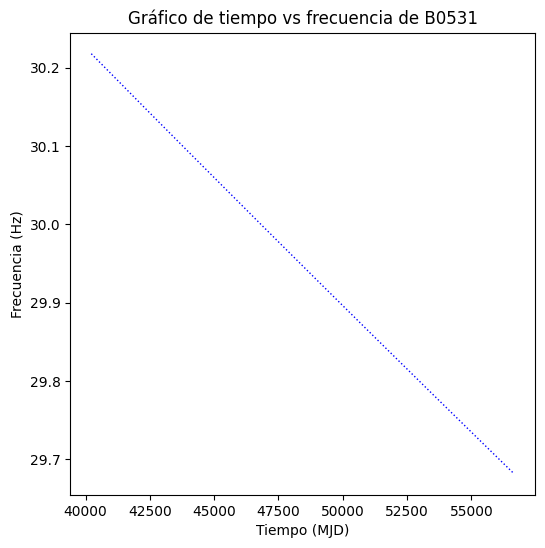

11 11


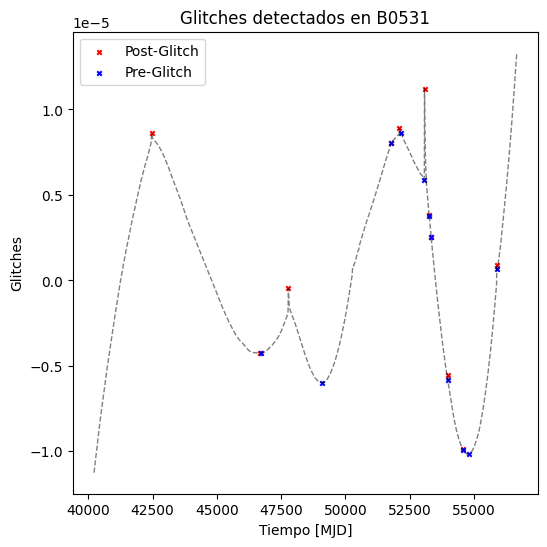

In [54]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(tiempoB0531,frecuenciaB0531,color="blue",linewidth=1,linestyle="dotted")
ax.set_title("Gráfico de tiempo vs frecuencia de B0531")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()

# calcular residuo:
residuoB0531 = ajuste_polinomial(tiempoB0531,frecuenciaB0531, 3)

# Gráfico pre/post-glitches
tiempoGlitchB0531, glitchesB0531 = obtener_glitches_y_tiempos(tiempoB0531, residuoB0531, "B0531", 5)

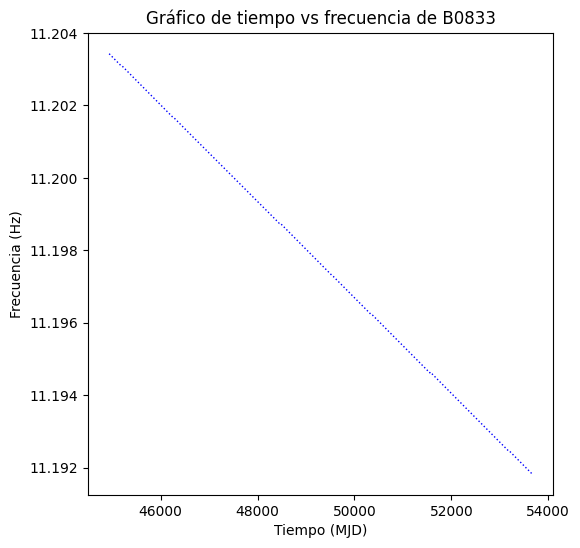

12 12


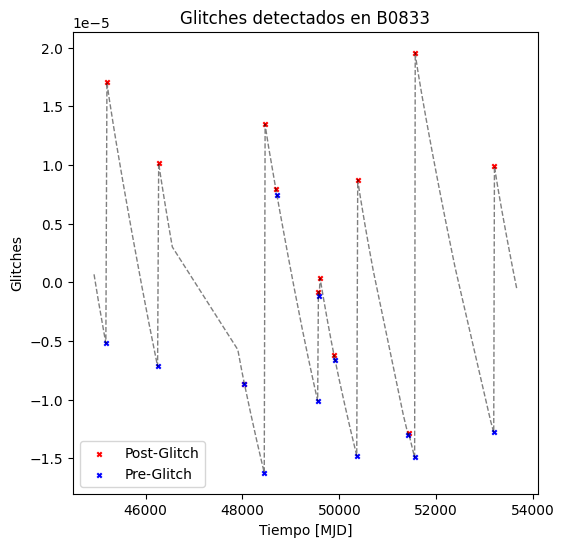

In [45]:
# tiempoB0833, frecuenciaB0833, incertezaB0531

# Gráfico de tiempo vs frecuencia de B0833
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(tiempoB0833, frecuenciaB0833, color="blue", linewidth=1, linestyle="dotted")
ax.set_title("Gráfico de tiempo vs frecuencia de B0833")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")
plt.show()

# Calcular residuo:
residuoB0833, m, b = ajuste_residuos_lineal(tiempoB0833, frecuenciaB0833)

# Gráfico pre/post-glitches
tiempoGlitchB0833, glitchesB0833 = obtener_glitches_y_tiempos(tiempoB0833, residuoB0833, "B0833")

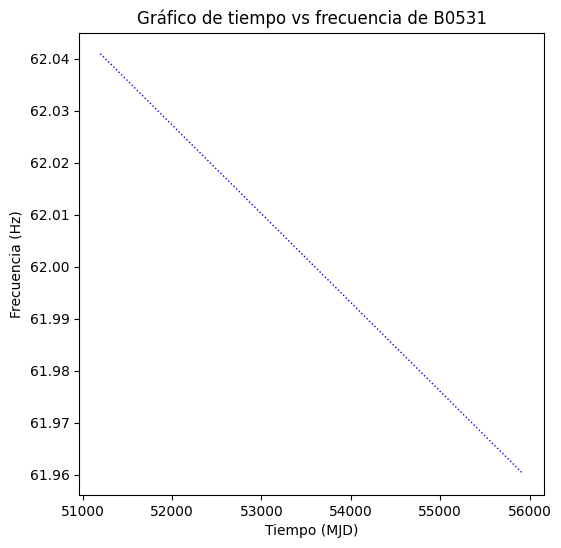

41 41


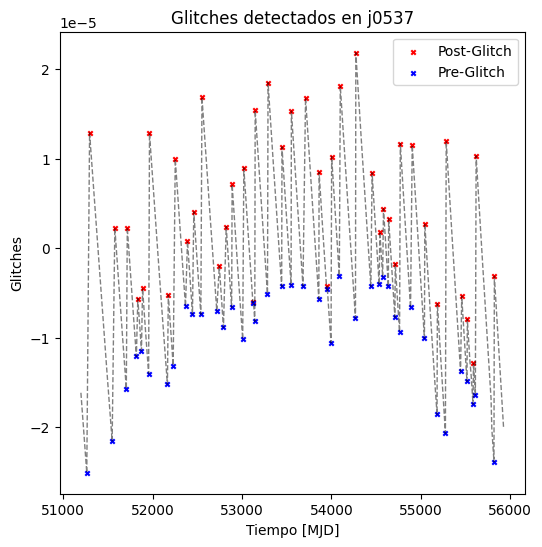

In [46]:
#tiempoJ0537, frecuenciaJ0537, incertezaJ0537
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(tiempoJ0537,frecuenciaJ0537,color="blue",linewidth=1,linestyle="dotted")
ax.set_title("Gráfico de tiempo vs frecuencia de B0531")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()

#calcular residuo:
residuoJ0537, m, b = ajuste_residuos_lineal(tiempoJ0537,frecuenciaJ0537)

# Gráfico pre/post-glitches
tiempos, glitches = obtener_glitches_y_tiempos(tiempoJ0537, residuoJ0537, "j0537")


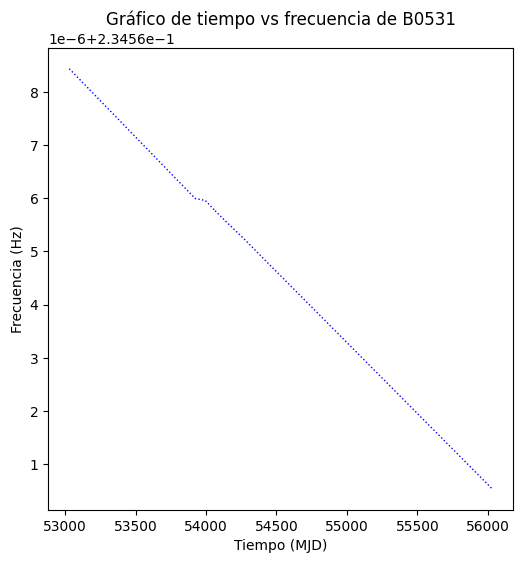

2 2


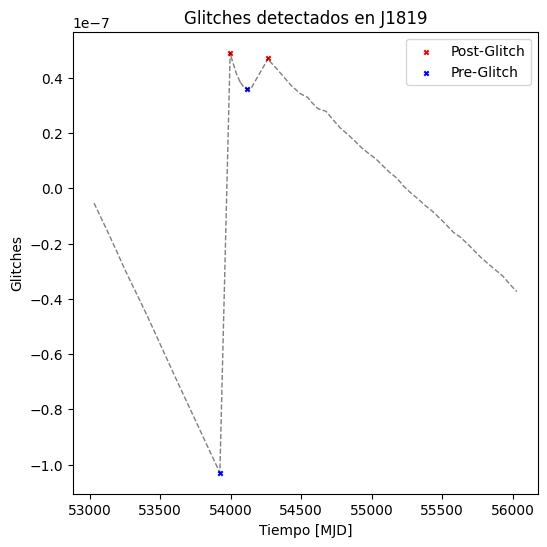

In [47]:
#tiempoJ1819, frecuenciaJ1819, incertezaJ1819
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(tiempoJ1819,frecuenciaJ1819,color="blue",linewidth=1,linestyle="dotted")
ax.set_title("Gráfico de tiempo vs frecuencia de B0531")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()

#calcular residuo:
residuoJ1819, m, b = ajuste_residuos_lineal(tiempoJ1819,frecuenciaJ1819)

# Gráfico pre/post-glitches
tiempoGlitchesJ1819, glitchesJ1819 = obtener_glitches_y_tiempos(tiempoJ1819, residuoJ1819, "J1819", 5)




Bienvenido a Glitch Finder!

Desea ingresar datos para analizar?
 1.- Sí   2.- No

Ingrese su opción: 1

Ingrese la dirección del archivo: /content/frec_J0537.dat
Ingrese el nombre de su púlsar: j0537



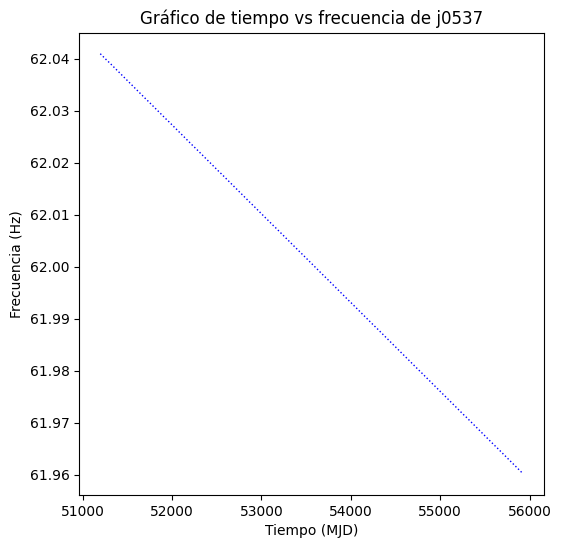


Qué tipo de ajuste desea realizar?
 1.- Lineal   2.- Polinomial

Ingrese su opción: 1

Ingrese el paso entre peaks: 1



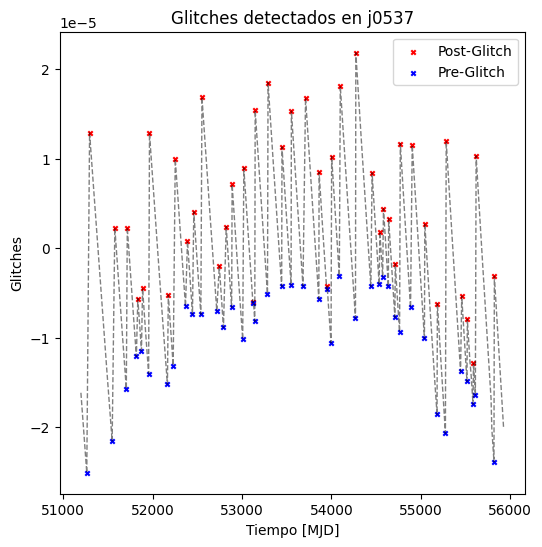


Desea ingresar datos para analizar?
 1.- Sí   2.- No

Ingrese su opción: 2

Gracias por usar Glitch Finder!


In [74]:
flag = True

print("Bienvenido a Glitch Finder!\n")
while flag:
  print("Desea ingresar datos para analizar?\n",
        "1.- Sí   2.- No\n")

  opt = input("Ingrese su opción: ")
  print()

  if opt == "1":

    flag2 = True
    while flag2:

      direccion = input("Ingrese la dirección del archivo: ")
      nombreArchivo = input("Ingrese el nombre de su púlsar: ")
      print()
      try:
        tiempoArchivo, frecuenciaArchivo, incertezasArchivo = leerArchivo(direccion)
        fig, ax = plt.subplots(1,1,figsize=(6,6))

        ax.plot(tiempoArchivo, frecuenciaArchivo, color="blue",linewidth=1,linestyle="dotted")
        ax.set_title(f"Gráfico de tiempo vs frecuencia de {nombreArchivo}")
        ax.set_xlabel("Tiempo (MJD)")
        ax.set_ylabel("Frecuencia (Hz)")
        plt.show()
        print()
        flag2 = False

      except:
        print("Reingrese sus datos, realmente ingresó una dirección válida?\n")

    if flag2 == False:
      flag3 = True
      while flag3:
        print("Qué tipo de ajuste desea realizar?\n",
              "1.- Lineal   2.- Polinomial\n")

        opt2 = input("Ingrese su opción: ")
        print()

        if int(opt2) == 1:

          pasoPeaks = input("Ingrese el paso entre peaks: ")
          print()
          try:
            residuoArchivo, m, b = ajuste_residuos_lineal(tiempoArchivo,frecuenciaArchivo)
            tiempoGlitchesArchivo, glitchesArchivo = obtener_glitches_y_tiempos(tiempoArchivo, residuoArchivo, nombreArchivo, int(pasoPeaks))
            flag3 = False
            print()

          except:
            print("No se pudo realizar el análisis, intente ingresar un paso válido\n")

        elif int(opt2) == 2:

          pasoPeaks = input("Ingrese el paso entre peaks: ")
          grado = input("Ingrese el grado del ajuste polinomial: ")
          print()

          try:
            residuoArchivo = ajuste_polinomial(tiempoArchivo,frecuenciaArchivo, int(grado))
            tiempoGlitchesArchivo, glitchesArchivo = obtener_glitches_y_tiempos(tiempoArchivo, residuoArchivo, nombreArchivo, int(pasoPeaks))
            flag3 = False
            print()

          except:
            print("No se pudo realizar el análisis, intente ingresar un paso válido\n")

        else:
          print("Opción inválida, por favor pruebe de nuevo\n")

  elif opt == "2":
    print("Gracias por usar Glitch Finder!")
    flag = False

  else:
    print("Opción inválida, por favor pruebe de nuevo\n")
